In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xplique keras_cv
!cp "/content/drive/MyDrive/Harmonizer zoo/data/cka_imagenet_val.npy" ./
!cp -r "/content/drive/MyDrive/Saliency Strike Back/data/resnet50_explanations" ./

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 24.3 MB/s eta 0:00:00


In [2]:
import xplique
from xplique.attributions import *
import tensorflow as tf
import numpy as np
import keras_cv
from keras_cv.models import *

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

<ipython-input-2-f6199f6b849b>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)

def preprocess(images):
  return tf.keras.applications.resnet_v2.preprocess_input(np.array(images, dtype=np.float32))

102869336/102869336 [==============================] - 1s 0us/step


In [4]:
X = np.load('cka_imagenet_val.npy')
X = preprocess(X)
Y = tf.one_hot(np.argmax(model.predict(X, 256), -1), 1_000)
X.shape, Y.shape

20/20 [==============================] - 33s 852ms/step


((5000, 224, 224, 3), TensorShape([5000, 1000]))

In [5]:
X.shape, Y.shape

((5000, 224, 224, 3), TensorShape([5000, 1000]))

# Generate and save explanations

In [6]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)
model.layers[-1].activation = tf.nn.sigmoid

In [7]:
from xplique.attributions import *
from xplique.metrics import *

In [57]:
def permute_ax1(x):
  x = x.copy()
  x = np.moveaxis(x, 1, 0)
  np.random.shuffle(x)
  x = np.moveaxis(x, 1, 0)
  return x


def random_permute(x):
  x = np.array(x).copy()
  s = x.shape
  x = x.reshape((len(x), -1, 3))
  x = permute_ax1(x)
  return x.reshape(s)

def downsample_upsample(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = tf.image.resize(x, s, method="nearest").numpy()
  return x

def local_permute(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = random_permute(x)
  x = tf.image.resize(x, s, method="nearest").numpy()
  return x

def scramble_phase(x):
  spectrum = np.fft.fft2(x)
  amplitude = np.abs(spectrum)

  phase = np.angle(spectrum)
  phase = random_permute(phase)
  #phase = np.random.normal(phase.mean(), phase.std(), phase.shape)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x

def scramble_amplitude(x):
  spectrum = np.fft.fft2(x)

  amplitude = np.abs(spectrum)
  amplitude = random_permute(amplitude)

  phase = np.angle(spectrum)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x


baselines = {
    'zero': lambda x : tf.zeros(x.shape).numpy(),
    'uniform': lambda x : tf.random.uniform(x.shape, -1, 1).numpy(),
    'normal': lambda x : tf.clip_by_value(tf.random.normal(x.shape), -1, 1).numpy(),
    'permutation': lambda x : random_permute(x),
    'local_mean': lambda x : downsample_upsample(x),
    'local_permutation': lambda x : local_permute(x),
    'mean': lambda x : np.ones(x.shape) * np.mean(x, (1, 2))[:, None, None, :],
    'median': lambda x : np.ones(x.shape) * np.median(x, (1, 2))[:, None, None, :],
    'random_color': lambda x : np.ones(x.shape) * (np.random.rand(3) * 2 - 1.),
    'scramble_phase': lambda x : scramble_phase(x),
    'scramble_amplitude': lambda x : scramble_amplitude(x)
}

(1024, 1024, 1) (1024, 1024, 3)


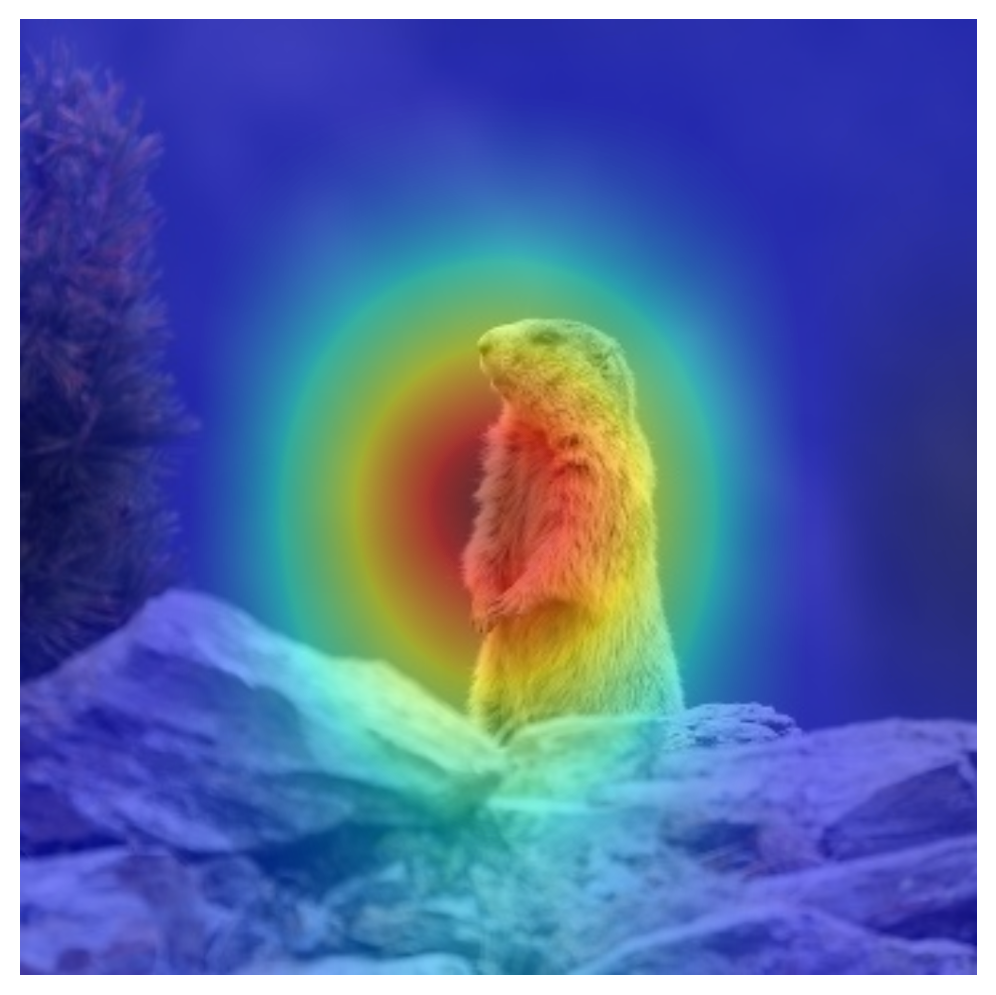

In [48]:
import cv2

h = np.array([
    [0.0, 0.1, 0.0],
    [0.0, 1.0, 0.0],
    [0.05, 0.3, 0.01],
])
h = tf.image.resize(h[:, :, None], (1024, 1024), method="bicubic")

img = cv2.imread('marmotte.jpg').astype(np.float32)[...,::-1] / 127.0 - 1.0
img = tf.image.resize(img, (1024, 1024))
show(img)
show(h, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.savefig('h.png', dpi=300, transparent=True)
print(h.shape, img.shape)

In [49]:
for b_text, b_function in baselines.items():
  b0 = np.array(b_function(img[None, :, :, :]))[0]

  switch = np.array(h > 0.5).astype(np.float32)
  p = img * switch + b0 * (1.0 - switch)

  show(p)
  plt.tight_layout()
  plt.savefig(f'{b_text}.png', dpi=300, transparent=True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [50]:
l = 300
bs = 128

deletion = Deletion(model, X[:l], Y[:l], batch_size=bs, steps=5, baseline_mode = 0.0)
insertion = Insertion(model, X[:l], Y[:l], batch_size=bs, steps=5)
muf = MuFidelity(model, X[:l], Y[:l], batch_size=bs, nb_samples=128, grid_size=12)

In [58]:
import os

l = 300
bs = 128

for baseline_text, baseline_func in baselines.items():
  RESULTS = []

  deletion = Deletion(model, X[:l], Y[:l], batch_size=bs, steps=5, baseline_mode = baseline_func)
  insertion = Insertion(model, X[:l], Y[:l], batch_size=bs, steps=5, baseline_mode = baseline_func)
  #muf = MuFidelity(model, X[:l], Y[:l], batch_size=bs, nb_samples=128, grid_size=12, baseline_mode = baseline_func)

  for p in os.listdir('resnet50_explanations'):
    h = np.load('resnet50_explanations/'+p)[:l]

    if len(h.shape) == 4:
      h = np.mean(h, -1)

    h = np.abs(h)

    s_del = deletion(np.array(h))
    s_ins = insertion(np.array(h))
    #s_muf = muf(h)

    print(baseline_text, p, s_del, s_ins)
    RESULTS.append((p, s_del, s_ins, s_muf))

  fn = baseline_text + ".npy"
  np.save(fn, RESULTS)
  !cp {fn} "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet"



zero resnet50_GuidedBackprop.npy 0.7128820419311523 0.9206457138061523
zero resnet50_Occlusion.npy 0.7082298398017883 0.8358743786811829
zero resnet50_SobolAttributionMethod.npy 0.7286586761474609 0.9157744646072388
zero resnet50_Saliency.npy 0.7749654054641724 0.8621150851249695
zero resnet50_IntegratedGradients.npy 0.7514544725418091 0.8942121267318726
zero resnet50_VarGrad.npy 0.7514256238937378 0.9183717966079712
zero resnet50_SmoothGrad.npy 0.741315484046936 0.903426468372345
zero resnet50_SquareGrad.npy 0.7519910335540771 0.9185979962348938
zero resnet50_GradCAMPP.npy 0.7435828447341919 0.9259351491928101
zero resnet50_DeconvNet.npy 0.7642708420753479 0.8491586446762085
zero resnet50_GradCAM.npy 0.7732097506523132 0.9245476722717285
zero resnet50_GradientInput.npy 0.769544780254364 0.8767378926277161
zero resnet50_Rise.npy 0.7515383958816528 0.933813214302063
zero resnet50_HsicAttributionMethod.npy 0.7124066352844238 0.9220234155654907
uniform resnet50_GuidedBackprop.npy 0.660672

In [60]:
for baseline_text, baseline_func in baselines.items():
  print(baseline_text)

  data = np.load(f'{baseline_text}.npy', allow_pickle=True)[()]

  methods = np.array([m for m, d, i, _ in data])

  best_del = np.argsort([d for m, d, i, _ in data])
  best_ins = np.argsort([i for m, d, i, _ in data])[::-1]

  for mi in best_del:
    print(methods[mi])

  print('\n\n')


zero
resnet50_Occlusion.npy
resnet50_HsicAttributionMethod.npy
resnet50_GuidedBackprop.npy
resnet50_SobolAttributionMethod.npy
resnet50_SmoothGrad.npy
resnet50_GradCAMPP.npy
resnet50_VarGrad.npy
resnet50_IntegratedGradients.npy
resnet50_Rise.npy
resnet50_SquareGrad.npy
resnet50_DeconvNet.npy
resnet50_GradientInput.npy
resnet50_GradCAM.npy
resnet50_Saliency.npy



uniform
resnet50_GuidedBackprop.npy
resnet50_IntegratedGradients.npy
resnet50_DeconvNet.npy
resnet50_Occlusion.npy
resnet50_SmoothGrad.npy
resnet50_GradientInput.npy
resnet50_SquareGrad.npy
resnet50_HsicAttributionMethod.npy
resnet50_VarGrad.npy
resnet50_SobolAttributionMethod.npy
resnet50_Saliency.npy
resnet50_GradCAMPP.npy
resnet50_Rise.npy
resnet50_GradCAM.npy



normal
resnet50_GuidedBackprop.npy
resnet50_IntegratedGradients.npy
resnet50_SmoothGrad.npy
resnet50_DeconvNet.npy
resnet50_GradientInput.npy
resnet50_Occlusion.npy
resnet50_SquareGrad.npy
resnet50_VarGrad.npy
resnet50_Saliency.npy
resnet50_HsicAttributionMethod.np

In [61]:
for baseline_text, baseline_func in baselines.items():
  print(baseline_text)

  data = np.load(f'{baseline_text}.npy', allow_pickle=True)[()]

  methods = np.array([m for m, d, i, _ in data])

  best_del = np.argsort([d for m, d, i, _ in data])
  best_ins = np.argsort([i for m, d, i, _ in data])[::-1]

  for mi in best_ins:
    print(methods[mi])

  print('\n\n')


zero
resnet50_Rise.npy
resnet50_GradCAMPP.npy
resnet50_GradCAM.npy
resnet50_HsicAttributionMethod.npy
resnet50_GuidedBackprop.npy
resnet50_SquareGrad.npy
resnet50_VarGrad.npy
resnet50_SobolAttributionMethod.npy
resnet50_SmoothGrad.npy
resnet50_IntegratedGradients.npy
resnet50_GradientInput.npy
resnet50_Saliency.npy
resnet50_DeconvNet.npy
resnet50_Occlusion.npy



uniform
resnet50_Rise.npy
resnet50_GradCAMPP.npy
resnet50_GradCAM.npy
resnet50_HsicAttributionMethod.npy
resnet50_SobolAttributionMethod.npy
resnet50_VarGrad.npy
resnet50_SquareGrad.npy
resnet50_GuidedBackprop.npy
resnet50_IntegratedGradients.npy
resnet50_SmoothGrad.npy
resnet50_GradientInput.npy
resnet50_Saliency.npy
resnet50_Occlusion.npy
resnet50_DeconvNet.npy



normal
resnet50_Rise.npy
resnet50_GradCAMPP.npy
resnet50_GradCAM.npy
resnet50_HsicAttributionMethod.npy
resnet50_SobolAttributionMethod.npy
resnet50_VarGrad.npy
resnet50_SquareGrad.npy
resnet50_GuidedBackprop.npy
resnet50_IntegratedGradients.npy
resnet50_SmoothGrad

In [ ]:
import os

for p in os.listdir('resnet50_explanations'):
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  s_del = deletion(h)
  s_ins = insertion(h)
  s_muf = muf(h)

  print(p, s_del, s_ins, s_muf)

resnet50_GradCAM.npy 0.7874435186386108 0.9272844195365906 0.06702462222518364
resnet50_GuidedBackprop.npy 0.7104595303535461 0.9181774258613586 0.06269835176444336
resnet50_HsicAttributionMethod.npy 0.7270568013191223 0.9253481030464172 0.057911880747071987
resnet50_GradientInput.npy 0.7567116022109985 0.8750414848327637 0.05083232033901102


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


resnet50_Occlusion.npy 0.7078730463981628 0.8360959887504578 0.06555307200310324
resnet50_SquareGrad.npy 0.7466303110122681 0.9175025820732117 0.07152428994165462
resnet50_VarGrad.npy 0.7455980181694031 0.919355571269989 0.07226865606645876
resnet50_SobolAttributionMethod.npy 0.7437445521354675 0.9232309460639954 0.05772241505792069
resnet50_SmoothGrad.npy 0.7382704615592957 0.898871123790741 0.07799797402674685
resnet50_DeconvNet.npy 0.768138587474823 0.8438582420349121 0.1385666403192454
resnet50_Saliency.npy 0.7676782608032227 0.8525184392929077 0.0723284043984989
resnet50_Rise.npy 0.7644363045692444 0.9367285966873169 0.06618524118298776
resnet50_GradCAMPP.npy 0.7541747689247131 0.931303858757019 0.09297190683362602
resnet50_IntegratedGradients.npy 0.7526863813400269 0.8893162608146667 0.06854749778070868


In [ ]:
to_improve = [
 'resnet50_GuidedBackprop.npy',
 'resnet50_GradientInput.npy',
 'resnet50_SquareGrad.npy',
 'resnet50_VarGrad.npy',
 'resnet50_SmoothGrad.npy',
 'resnet50_DeconvNet.npy',
 'resnet50_Saliency.npy',
 'resnet50_IntegratedGradients.npy']

In [ ]:
def low_pass_mask(size, bandwith):
    center = (int(size/2), int(size/2))
    Y, X = np.ogrid[:size, :size]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= bandwith
    mask = mask.astype(np.float32)

    return mask

def cut_freq(phis, bandwith):
  if len(phis.shape) == 4:
    phis = np.mean(phis, -1)
  phis = np.abs(phis)

  specs = np.fft.fft2(phis)
  mask = np.fft.fftshift(low_pass_mask(224, bandwith))
  specs *= mask

  phis_cutted = np.fft.ifft2(specs).astype(np.float32)
  return phis_cutted

In [ ]:
for p in to_improve:
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  for sigma in [100, 50, 20, 15, 10, 8, 5, 3]:

    h_sigma = cut_freq(h, sigma)

    s_del = deletion(h_sigma)
    s_ins = insertion(h_sigma)
    #s_muf = muf(h)

    print(p, sigma, s_del, s_ins, s_ins - s_del)

  print('\n\n\n')


In [ ]:
for p in to_improve:
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  for sigma in [8, 5]:

    h_sigma = cut_freq(h, sigma)

    s_del = deletion(h_sigma)
    s_ins = insertion(h_sigma)
    s_muf = muf(h_sigma)

    print(p, sigma, s_del, s_ins, s_ins - s_del, s_muf)

  print('\n\n\n')


<ipython-input-20-e985ffe7b816>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  phis_cutted = np.fft.ifft2(specs).astype(np.float32)


resnet50_GuidedBackprop.npy 8 0.6913203001022339 0.9108409881591797 0.2195206880569458 0.06090380947505527
resnet50_GuidedBackprop.npy 5 0.7178225517272949 0.9180701971054077 0.2002476453781128 0.058193463520230096




resnet50_GradientInput.npy 8 0.7478708624839783 0.8778724670410156 0.13000160455703735 0.05014007755957404
resnet50_GradientInput.npy 5 0.765465259552002 0.8876684904098511 0.12220323085784912 0.049988370977192664




resnet50_SquareGrad.npy 8 0.7384991645812988 0.9213959574699402 0.18289679288864136 0.06953857843177876
resnet50_SquareGrad.npy 5 0.7556474804878235 0.9322643280029297 0.1766168475151062 0.06959643186330292




resnet50_VarGrad.npy 8 0.7430763840675354 0.9228439331054688 0.17976754903793335 0.06962328480168234
resnet50_VarGrad.npy 5 0.7531355619430542 0.9259392023086548 0.17280364036560059 0.0697130876958039




resnet50_SmoothGrad.npy 8 0.729398787021637 0.9193663597106934 0.1899675726890564 0.07743030742016327
resnet50_SmoothGrad.npy 5 0.7427111268043518 